# Assignment 3

Restricted Boltzmann Machine (RBM) + Constructive Divergence


# Restricted Boltzmann Machine (RBM) and Contrastive Divergence  

## Description  
We begin by defining the steps of the **Contrastive Divergence (CD)** algorithm, used for training an RBM. Below are the detailed steps to implement a generalized RBM.  

### Iterations  

1. **Initialization**  
   Start with an input vector $ v^{(0)} $ (real-world data).  

2. **Hidden Layer Calculation**  
   $$
   P(h_j^{(0)} \mid v^{(0)}) = \sigma\left(\sum_i v_i^{(0)} w_{ij} + b_j\right)
   $$  

3. **Visible Neurons Reconstruction**  
   $$
   P(v_i^{(1)} \mid h^{(0)}) = \sigma\left(\sum_j h_j^{(0)} w_{ij} + a_i\right)
   $$  

4. **Hidden Neurons Recalculation**  
   $$
   P(h_j^{(1)} \mid v^{(1)}) = \sigma\left(\sum_i v_i^{(1)} w_{ij} + b_j\right)
   $$  

5. **Weights Update**  
   $$
   \Delta w_{ij} = \eta \left( v_i^{(0)} h_j^{(0)} - v_i^{(1)} h_j^{(1)} \right)
   $$  

### Notes  
- $\sigma$: Sigmoid activation function.  
- $\eta$: Learning rate.  
- Steps 2-4 form a **Gibbs sampling step**, used to approximate the gradient during training.

## Implementation
First, we define the sigmoid function:

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Next, we define methods to calculate the probabilities for hidden and visible neurons:

In [ ]:
# Calculate hidden neuron probabilities
def prop_up(v, W, b):
    return sigmoid(np.dot(v, W) + b)

# Calculate visible neuron probabilities
def prop_down(h, W, a):
    return sigmoid(np.dot(h, W.T) + a)

We also need a method to sample binary values from a probability distribution:

In [ ]:
def sample_prob(probs):
    return np.random.binomial(1, probs)

The Contrastive Divergence algorithm can then be implemented as follows:

In [ ]:
def contrastive_divergence(v0, W, a, b, lr, k=1):
    # Step 1: v0 (real input data)
    # Step 2 (Hidden layer calculation)
    h_prob_0 = prop_up(v0, W, b)
    h_state = sample_prob(h_prob_0)

    v_state, h_prob, v_prob = None, None, None
    for step in range(k):
        # Step 3 (Visible Neurons Reconstruction)
        v_prob = prop_down(h_state, W, a)
        v_state = sample_prob(v_prob)

        # Step 4 (Hidden neurons recalc)
        h_prob = prop_up(v_state, W, b)
        h_state = sample_prob(h_prob)

    # Step 5: Update weights and biases
    W += lr * (np.outer(v0, h_prob_0) - np.outer(v_state, h_prob))
    a += lr * (v0 - v_state)
    b += lr * (h_prob_0 - h_prob)

    error = np.mean((v0 - v_prob) ** 2)

    return W, a, b, error

Finally, the training method for our RBM can be written as:

In [ ]:
def train_rbm(x, n_visible, n_hidden, epochs=10, k=1, lr=0.01):
    # Weight initialization from Gaussian distribution
    W = np.random.normal(0, 0.01, (n_visible, n_hidden))
    a = np.zeros(n_visible)  # Visible bias
    b = np.zeros(n_hidden)   # Hidden bias

    for epoch in range(epochs):
        error = 0
        for v in x:
            W, a, b, cd_error = contrastive_divergence(v, W, a, b, lr, k)
            error += cd_error

        error /= len(x)
        print(f"Epoch {epoch}, Error: {error:.4f}")

    return W, a, b

Where W, a, and b are the learned weights and biases.

The components we've defined represent the core of the assignment and form the foundation of the RBM class implemented in `rbmcd.py`. This class provides a more elegant and reusable approach to creating a trainable model, featuring additional methods such as:

- Model save/load to/from disk
- Image reconstruction from test samples
- Training monitoring utilities

For simplicity, we'll use this class rather than the basic implementation defined above.


## Training on MNIST Dataset

As per the project guidelines, the MNIST dataset was used to train the model. For image loading, we utilized the loader provided directly by Kaggle (available [here](https://www.kaggle.com/code/hojjatk/read-mnist-dataset)).

## Implementation
Below is the Python code for the training phase and results visualization on a specific digit arbitraly choosen:

Epoca 0, Errore: 0.0223
Epoca 1, Errore: 0.0165
Epoca 2, Errore: 0.0155
Epoca 3, Errore: 0.0151
Epoca 4, Errore: 0.0147
Epoca 5, Errore: 0.0145
Epoca 6, Errore: 0.0144
Epoca 7, Errore: 0.0143
Epoca 8, Errore: 0.0142
Epoca 9, Errore: 0.0141


<Figure size 600x300 with 0 Axes>

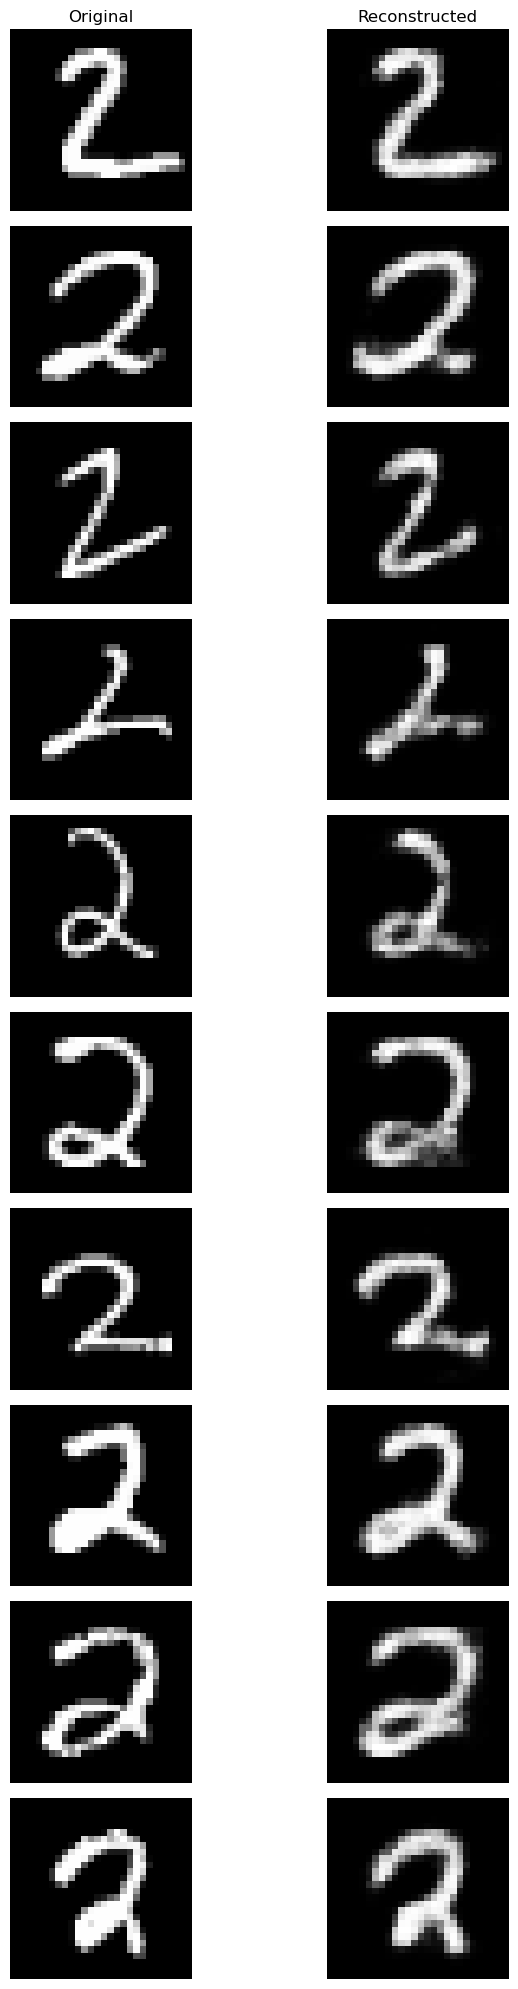

In [7]:
from matplotlib import pyplot as plt
from rbmcd import RBMCD
from sklearn.preprocessing import MinMaxScaler
from mnist_data_loader import MnistDataloader
import numpy as np

# Loading images from disk
mnist_dataloader = MnistDataloader()
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Reshaping images to match visible neurons
x_train = np.array(x_train).reshape((-1, 784))
x_test = np.array(x_test).reshape((-1, 784))

# Data normalization to [0,1] range
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# RBM model training
rbm = RBMCD(n_visible=784, n_hidden=128, learning_rate=0.01)
rbm.train(x_train, epochs=10)

# Test image reconstruction and visualization
plt.figure(figsize=(6, 3))

# Selecting a test image containing the digit "2"
digit = 2
sample_indices = [i for i, val in enumerate(y_test) if val == digit][0:10]

n_cols = 2
n_rows = len(sample_indices)

plt.figure(figsize=(8, 2 * n_rows))

for idx, sample_index in enumerate(sample_indices):
    sample = x_test[sample_index]

    # Gibbs sampling from test image
    x_pred = rbm.reconstruct(sample)

    plt.subplot(n_rows, n_cols, 2*idx + 1)
    if idx == 0:
        plt.title("Original")
    plt.imshow(sample.reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(n_rows, n_cols, 2*idx + 2)
    if idx == 0:
        plt.title("Reconstructed")
    plt.imshow(x_pred.reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

This results demonstrate that the RBM model successfully captured the essential features of the original digits. The reconstructions preserve the fundamental shape of digit "2" and many characteristic handwriting details, albeit with some minor variations.

### Key Observations:
1. **Reconstruction Quality**:
   - Outputs maintain recognizable digit structures
   - Most stylistic features of handwriting are preserved
   - Some samples show slight blurring effects, characteristic of generative models

2. **Model Performance**:
   - Distinctive features (e.g., bottom horizontal stroke and top curve) are accurately reproduced
   - The model appears to have learned meaningful representations of digit variations
   - Reconstruction fidelity suggests effective learning of the underlying probability distribution

3. **Training Effectiveness**:
   - High similarity between originals and reconstructions
   - Contrastive Divergence successfully identified representative parameters (weights and biases)
   - The model demonstrates good generalization capability for unseen samples

This example clearly shows how Gibbs' steps during the training phase correctly reduce the error at each step leading to results that are very faithful to the original.

## Training with Different K Values: Impact Analysis

The RBMCD implementation includes a configurable parameter `k` that determines the number of Gibbs sampling iterations per training data point. This section investigates how varying this parameter affects model performance, in particular we will use equally spaced sampling of the parameter `k`: 1, 5, 10

Training K=1...
Epoca 0, Errore: 0.0224
Epoca 1, Errore: 0.0167
Epoca 2, Errore: 0.0156
Epoca 3, Errore: 0.0151
Epoca 4, Errore: 0.0147
Epoca 5, Errore: 0.0145
Epoca 6, Errore: 0.0144
Epoca 7, Errore: 0.0143
Epoca 8, Errore: 0.0142
Epoca 9, Errore: 0.0141
Training K=5...
Epoca 0, Errore: 0.0390
Epoca 1, Errore: 0.0325
Epoca 2, Errore: 0.0309
Epoca 3, Errore: 0.0301
Epoca 4, Errore: 0.0295
Epoca 5, Errore: 0.0292
Epoca 6, Errore: 0.0290
Epoca 7, Errore: 0.0288
Epoca 8, Errore: 0.0286
Epoca 9, Errore: 0.0284
Training K=10...
Epoca 0, Errore: 0.0480
Epoca 1, Errore: 0.0411
Epoca 2, Errore: 0.0396
Epoca 3, Errore: 0.0387
Epoca 4, Errore: 0.0381
Epoca 5, Errore: 0.0378
Epoca 6, Errore: 0.0374
Epoca 7, Errore: 0.0373
Epoca 8, Errore: 0.0370
Epoca 9, Errore: 0.0369


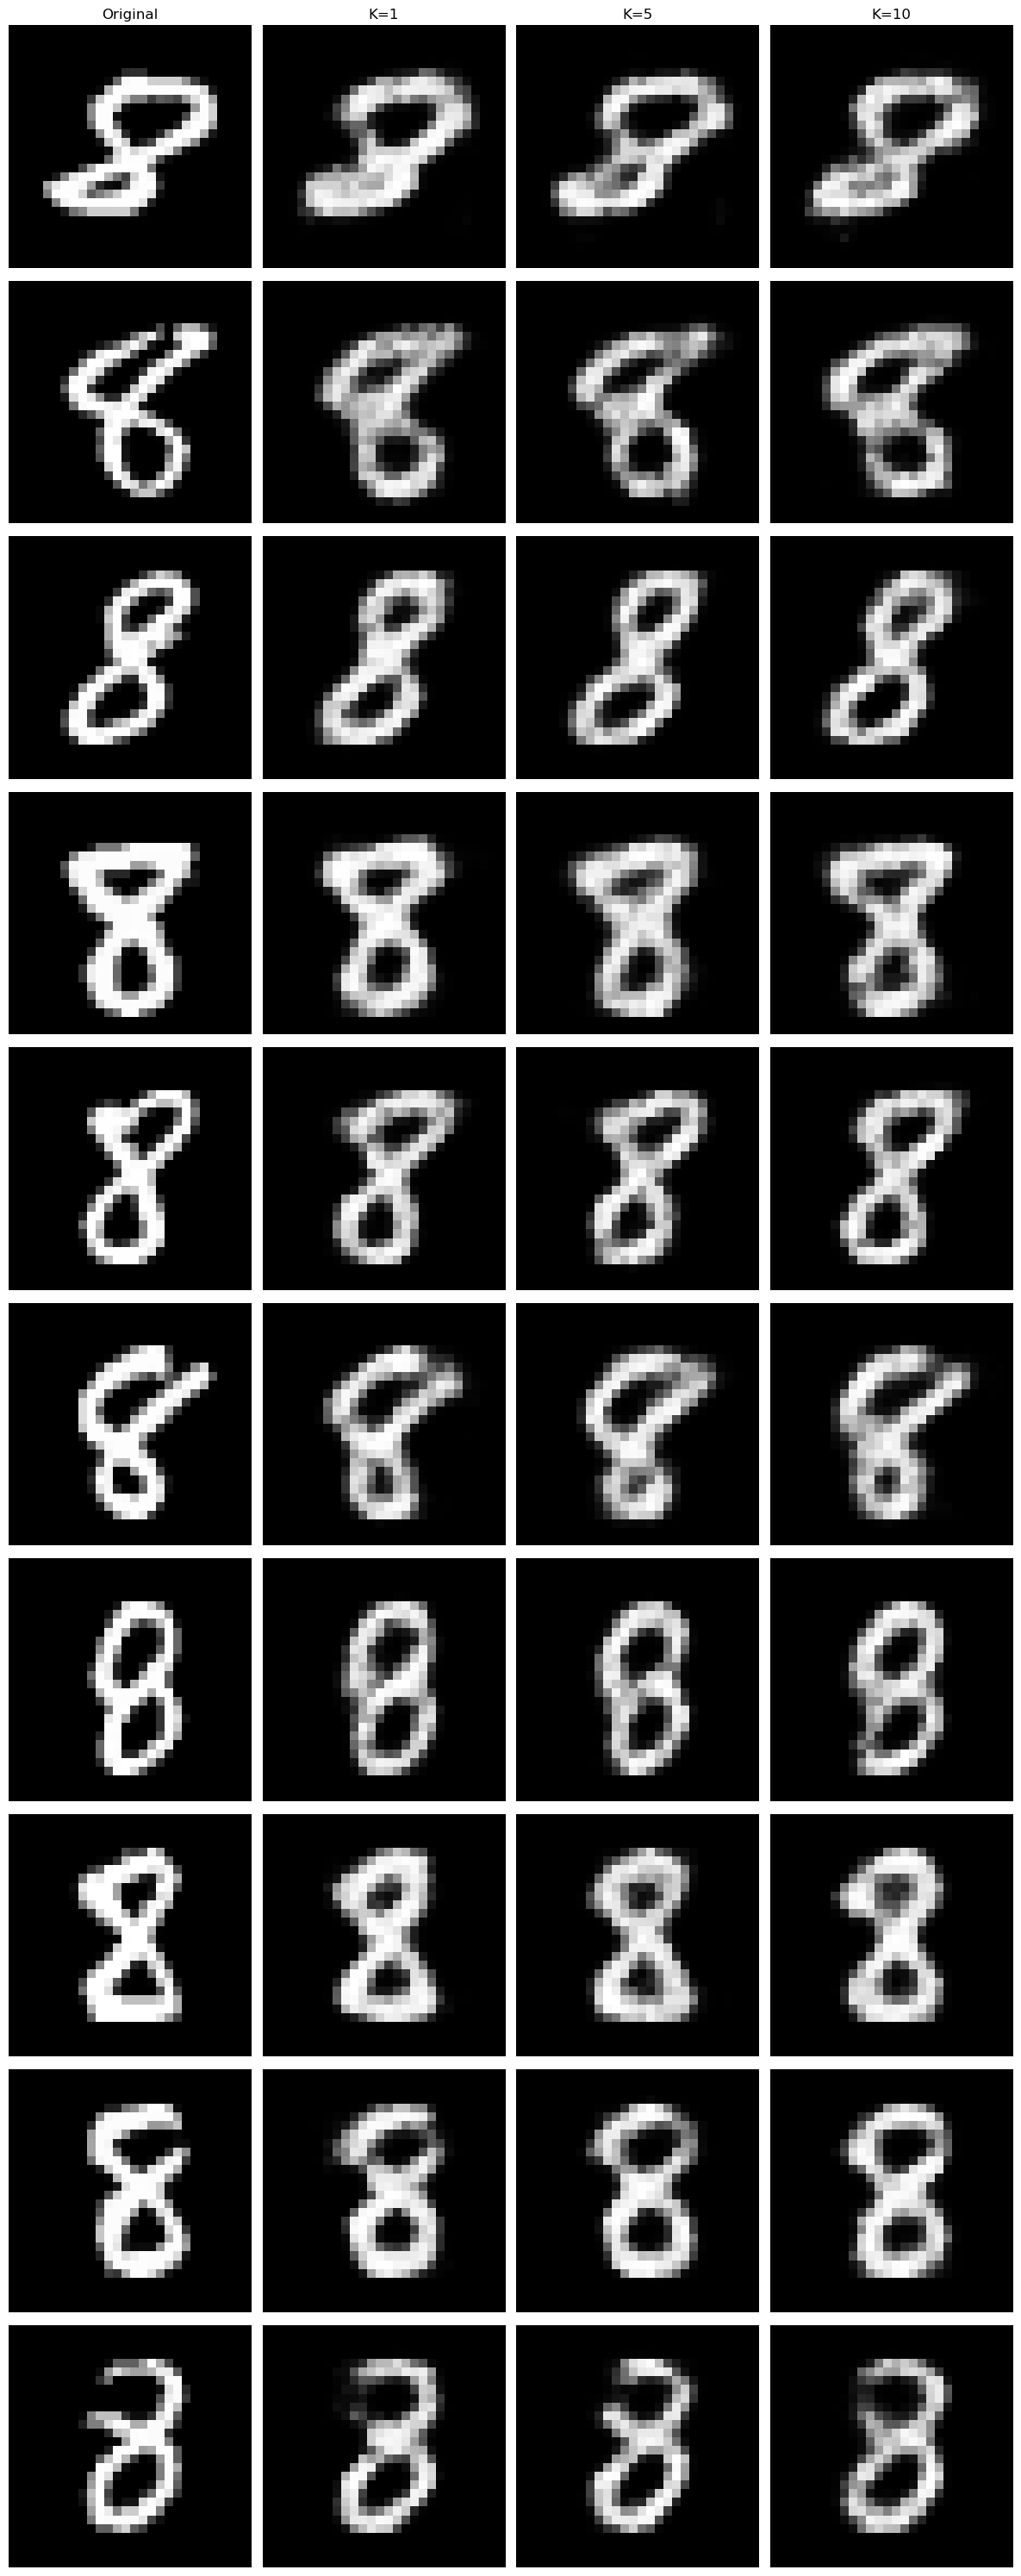

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mnist_data_loader import MnistDataloader
from rbmcd import RBMCD

# Loading MNIST
mnist_dataloader = MnistDataloader()
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Reshaping and scaling
x_train = np.array(x_train).reshape((-1, 784))
x_test = np.array(x_test).reshape((-1, 784))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Creation of the models with different K
rbm_k1 = RBMCD(n_visible=784, n_hidden=128, learning_rate=0.01)
rbm_k5 = RBMCD(n_visible=784, n_hidden=128, learning_rate=0.01)
rbm_k10 = RBMCD(n_visible=784, n_hidden=128, learning_rate=0.01)

# Training con diversi K
print("Training K=1...")
rbm_k1.train(x_train, epochs=10, k=1)

print("Training K=5...")
rbm_k5.train(x_train, epochs=10, k=5)

print("Training K=10...")
rbm_k10.train(x_train, epochs=10, k=10)

# Selezione di 5 immagini del digit 2
digit = 8
sample_indices = [i for i, val in enumerate(y_test) if val == digit][0:10]

# Plotting
n_samples = len(sample_indices)
n_cols = 4
plt.figure(figsize=(12, 3 * n_samples))

for idx, sample_index in enumerate(sample_indices):
    sample = x_test[sample_index]

    x_pred_k1 = rbm_k1.reconstruct(sample)
    x_pred_k5 = rbm_k5.reconstruct(sample)
    x_pred_k10 = rbm_k10.reconstruct(sample)

    plt.subplot(n_samples, n_cols, idx * n_cols + 1)
    if idx == 0: plt.title("Original")
    plt.imshow(sample.reshape(28, 28), cmap='gray')
    plt.axis('off')

    # K=1
    plt.subplot(n_samples, n_cols, idx * n_cols + 2)
    if idx == 0: plt.title("K=1")
    plt.imshow(x_pred_k1.reshape(28, 28), cmap='gray')
    plt.axis('off')

    # K=5
    plt.subplot(n_samples, n_cols, idx * n_cols + 3)
    if idx == 0: plt.title("K=5")
    plt.imshow(x_pred_k5.reshape(28, 28), cmap='gray')
    plt.axis('off')

    # K=10
    plt.subplot(n_samples, n_cols, idx * n_cols + 4)
    if idx == 0: plt.title("K=10")
    plt.imshow(x_pred_k10.reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

The examination of the output and reconstructed images reveals several key insights regarding the K parameter's effects:

### Reconstruction Quality Observations
- **Minimal visual impact**: Variation in K values (1, 5, 10) produced nearly indistinguishable results
- **Isolated cases**: Slight improvements in line sharpness and stroke thickness for digit "8" were occasionally noticeable at higher K values
- **Consistent performance**: Most reconstructions maintained similar quality across all K settings

### Training Dynamics Analysis
- **Error progression**:
  - Initial error increases proportionally with K
  - Higher K values show steeper early-training error curves
- **Overfitting evidence**:
  - Larger K values demonstrate characteristic overfitting patterns
  - Model appears to memorize dataset specifics rather than learn general features
  - Validation error plateaus while training error continues decreasing

### Practical Implications
The error values demonstrate that the CD-1 algorithm provides better reconstruction performance while being computationally less expensive than versions with higher K values. This counter-intuitive result suggests that, for this specific dataset, simpler approximations of the gradient work more effectively than theoretically more accurate ones.

## Custom RBM vs Oracle